In [1]:
# importing the libraries
# import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import os
from skimage.transform import resize

In [ ]:
# Download the dataset using pytorch datasets
import torchvision
torchvision.datasets.DTD("dataset", 'train', 1, download=True)

In [17]:
# Images to an array(with its class)
train_img = []
train_y = []
path = '.../images/'
i=0
for filename in os.listdir(path):
    for images in os.listdir(path+filename) :
        img = imread(path+filename+'/'+images)
        img = resize(img, (500, 500, 3))
        img = img.astype('float32')
        img /= 255.0
        assert(img.shape == (500,500,3))
        train_img.append(img)
        train_y.append(i)
    i += 1

In [18]:
# total number of images
len(train_img)

5640

In [19]:
# convert to numpy array
train_x = np.array(train_img)
# defining the target
train_x.shape

(5640, 500, 500, 3)

C:\Users\robofish\AppData\Local\Temp\ipykernel_10944\1972078053.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221), plt.imshow(train_x[i]*255)


(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x19b8f9552d0>)

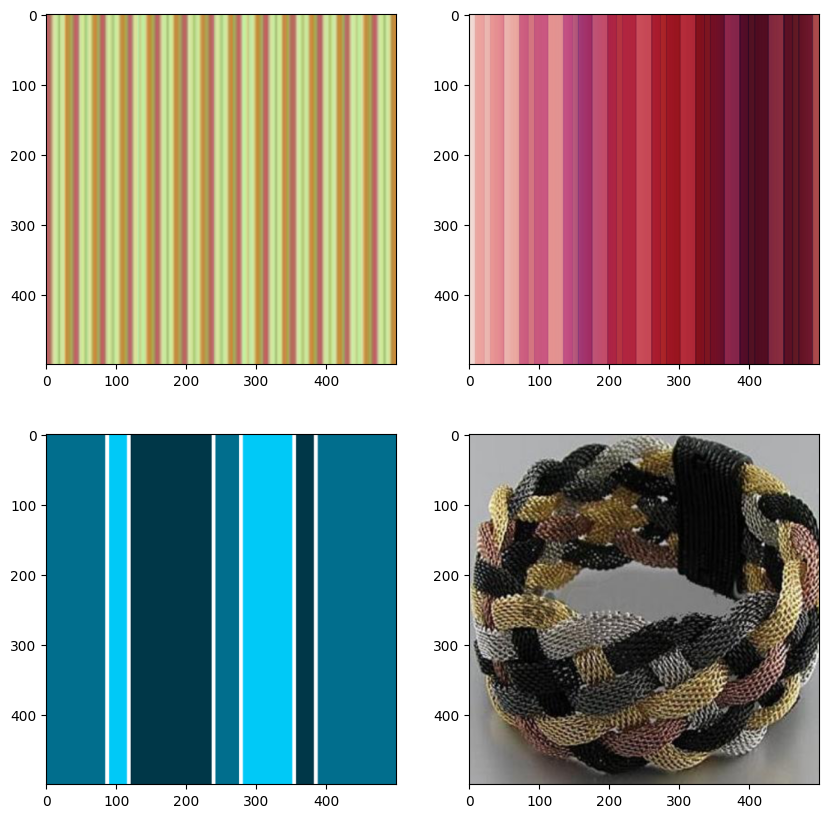

In [20]:
# Sample images

i = 0
plt.figure(figsize=(10,10))
plt.axis("off")
plt.subplot(221), plt.imshow(train_x[i]*255)
plt.subplot(222), plt.imshow(train_x[i+25]*255)
plt.subplot(223), plt.imshow(train_x[i+50]*255)
plt.subplot(224), plt.imshow(train_x[i+275]*255)

In [21]:
# Use test_train_split for seggregating training and validation set

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
val_y = np.array(val_y)
train_y = np.array(train_y)
print((train_x.shape, train_y.shape), (val_x.shape, val_y.shape))


((5076, 500, 500, 3), (5076,)) ((564, 500, 500, 3), (564,))


In [22]:
# Save the numpy arrays

np.save("train_x.npy",train_x)
np.save("train_y.npy",train_y)
np.save("val_x.npy",val_x)
np.save("val_y.npy",val_y)

In [2]:
# Load the numpy arrays

train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")
val_x = np.load("val_x.npy")
val_y = np.load("val_y.npy")

In [3]:
# converting training images into torch format
train_x = train_x.reshape(5076, 3, 500, 500)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([5076, 3, 500, 500]), torch.Size([5076]))

In [4]:
# converting validation images into torch format
val_x = val_x.reshape(564, 3, 500, 500)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([564, 3, 500, 500]), torch.Size([564]))

In [5]:
# building the model(Sequential layer)

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(3, 256, 5),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),

            Conv2d(256, 128, 5),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(128, 64, 5),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        
        )

        self.linear_layers = Sequential(
            Linear(64*59*59, 47)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=5)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=222784, out_features=47, bias=True)
  )
)


In [7]:
def train(epoch):
    model.train()
    tr_loss = 0
    loss_train = 0
    loss_val = 0


    for i in range(507):
        # getting the training set (This is set to batch size of 10)
        x_train, y_train = Variable(train_x[i:i+10]), Variable(train_y[i:i+10])
        
        # converting the data into GPU format
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = (y_train.type(torch.LongTensor)).cuda()

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()
        
        # prediction for training set
        output_train = model(x_train)

        if torch.cuda.is_available():
            output_train = output_train.cuda()
            
        # computing the training loss
        loss_train += criterion(output_train, y_train).item()
        if(i%100 == 0):
            print("Done : ", i)
        
    for i in range(56):
        # # prediction for validation set
        x_val, y_val = Variable(val_x[i:i+1]), Variable(val_y[i:i+1])
        if torch.cuda.is_available():
            x_val = x_val.cuda()
            y_val = (y_val.type(torch.LongTensor)).cuda()
        
        output_val = model(x_val)
        loss_val += criterion(output_val, y_val).item()
    
    # Converting loss to tensor format
    loss_train = Variable(torch.tensor((loss_train/5076.0),dtype=torch.float32) , requires_grad=True)
    
    # Appending for plotting graph
    val_losses.append(loss_val/564.0)
    train_losses.append(loss_train/5076.0)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()

    print('Epoch : ',epoch+1, '\t', 'val loss :',loss_val/564.0, '\t', 'train loss :',loss_train)

In [13]:
# defining the number of epochs
n_epochs = 25

# empty list to store training losses
train_losses = []

# empty list to store validation losses
val_losses = []

# training the model
for epoch in range(n_epochs):
    train(epoch)

Done :  0
Done :  100
Done :  200
Done :  300
Done :  400
Done :  500
Epoch :  1 	 val loss : 3.8498221204635943 	 train loss : tensor(0.3846, requires_grad=True)
Done :  0
Done :  100
Done :  200
Done :  300
Done :  400
Done :  500
Epoch :  2 	 val loss : 3.8498221204635943 	 train loss : tensor(0.3846, requires_grad=True)
Done :  0
Done :  100
Done :  200
Done :  300
Done :  400
Done :  500
Epoch :  3 	 val loss : 3.8498221204635943 	 train loss : tensor(0.3846, requires_grad=True)
Done :  0


KeyboardInterrupt: 

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

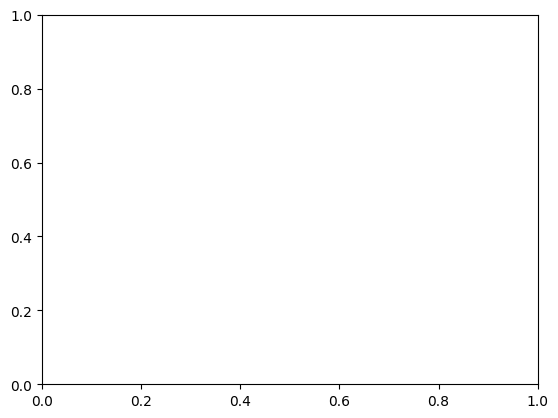

In [14]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [15]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

OutOfMemoryError: CUDA out of memory. Tried to allocate 132.33 GiB (GPU 0; 14.99 GiB total capacity; 6.32 GiB already allocated; 5.37 GiB free; 7.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF